In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [21]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
from pmdarima import auto_arima

In [5]:
df1 = pd.read_csv('Data/DailyTotalFemaleBirths.csv', index_col='Date', parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]

In [6]:
df2 = pd.read_csv('Data/TradeInventories.csv', index_col='Date', parse_dates=True)
df2.index.freq = 'MS'

## ARMA

<AxesSubplot: xlabel='Date'>

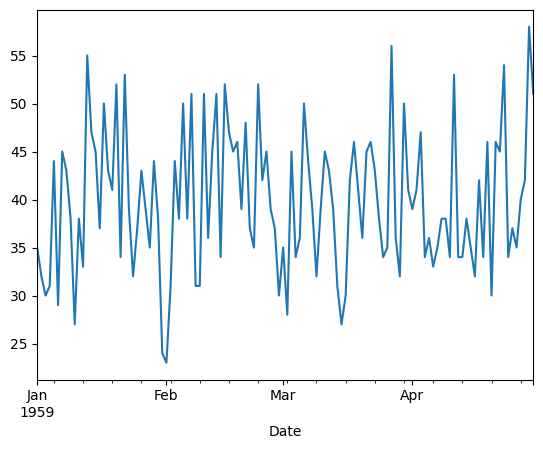

In [7]:
df1['Births'].plot()

### 디키 풀러 테스트 함수로 정상 데이터 확인

In [8]:
from statsmodels.tsa.stattools import adfuller

# 위 코드 정리된 함수
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [9]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### ARIMA 모델로 최적값 찾기

In [12]:
auto_arima(df1['Births'], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                        SARIMAX   Log Likelihood                -409.745
Date:                Sat, 10 Dec 2022   AIC                            823.489
Time:                        20:24:19   BIC                            829.064
Sample:                    01-01-1959   HQIC                           825.753
                         - 04-30-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.7833      0.687     57.896      0.000      38.437      41.130
sigma2        54.1197      8.319      6.506      0.000      37.815      70.424
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.36   Prob(JB):                         0.26
Heteroskedasticity (H):               0.80   Skew:                             0.26
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 예측하기

In [11]:
train = df1.iloc[:90]
test = df1.iloc[90:]

In [22]:
model = ARIMA(train['Births'], order=(2, 0, 2))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -307.812
Date:                Sat, 10 Dec 2022   AIC                            627.625
Time:                        20:35:06   BIC                            642.624
Sample:                    01-01-1959   HQIC                           633.673
                         - 03-31-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7576      1.017     39.094      0.000      37.764      41.751
ar.L1         -0.4659      1.004     -0.464      0.643      -2.433       1.501
ar.L2          0.5081      0.941      0.540      0.589      -1.336       2.352
ma.L1          0.5620     30.496      0.018      0.985     -59.209      60.333
ma.L2         -0.4379     13.222     -0.033      0.974     -26.353      25.477
sigma2        54.3734   1642.334      0.033      0.974   -3164.542    3273.289
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.96   Prob(JB):                         0.37
Heteroskedasticity (H):               0.92   Skew:                             0.16
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
start = len(train)
end = len(train) + len(test) -1

In [24]:
pred = result.predict(start, end).rename('ARMA (2, 2) Pred')

<AxesSubplot: xlabel='Date'>

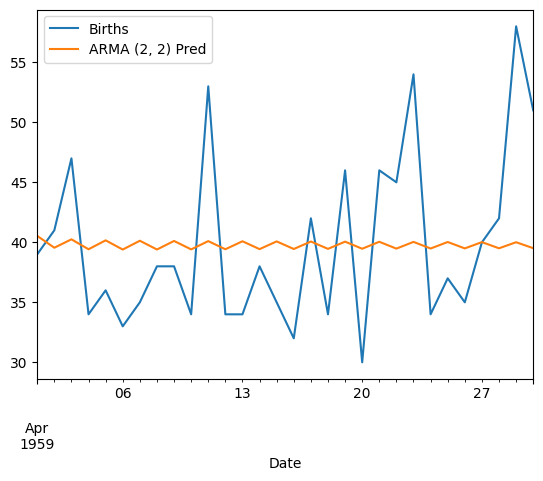

In [25]:
test['Births'].plot(legend=True)
pred.plot(legend=True)

In [27]:
test.mean()

Births    39.833333
dtype: float64

In [28]:
pred.mean()

39.78600017514722

> 잡음은 예측할 수 없지만, 평균을 찾음

## ARIMA

<AxesSubplot: xlabel='Date'>

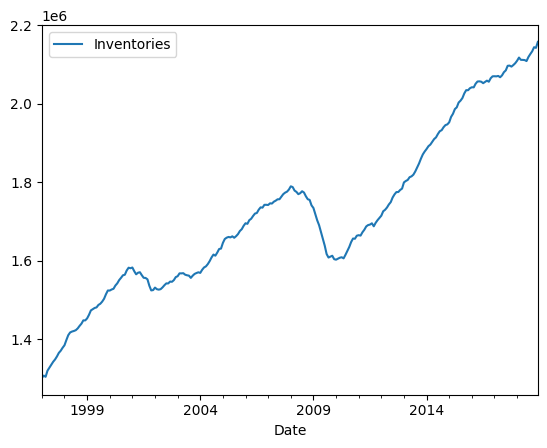

In [29]:
df2.plot()

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

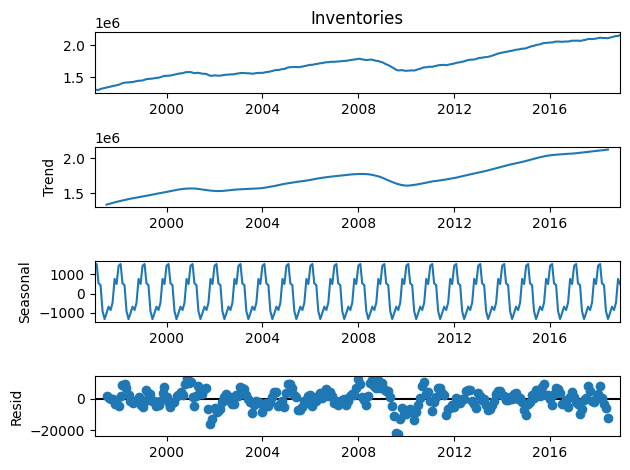

In [32]:
result = seasonal_decompose(df2['Inventories'], model='add')
result.plot();

In [34]:
auto_arima(df2['Inventories'], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Sat, 10 Dec 2022   AIC                           5348.037
Time:                        20:46:32   BIC                           5355.181
Sample:                    01-01-1997   HQIC                          5350.908
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### p,d,q 값 직접 찾아보기

### d값 찾기

디키-풀리 테스트에서 정상 데이터가 나올때까지 계속 차분을 진행

In [36]:
from statsmodels.tsa.statespace.tools import diff

In [37]:
df2['Diff_1'] = diff(df2['Inventories'], k_diff=1)

In [38]:
adf_test(df2['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### p, q값 찾기

- PACF가 날카롭게 깍이면 AR 모델 선택
- 이때, MA항은 0과 1을 대입해서 어떻게 오차가 적은지 직접 확인해야 함
- auto_arima로 가능하면 확인하기

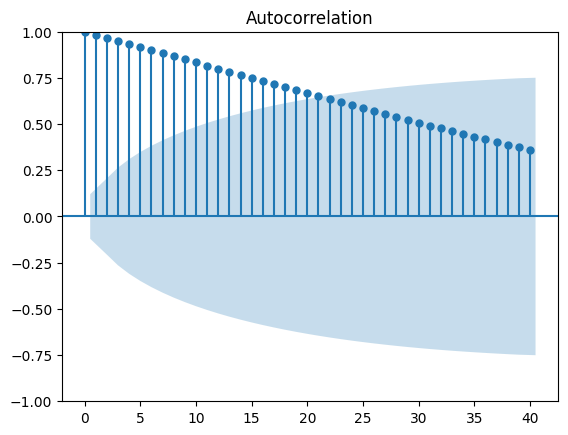

In [40]:
plot_acf(df2['Inventories'], lags=40);

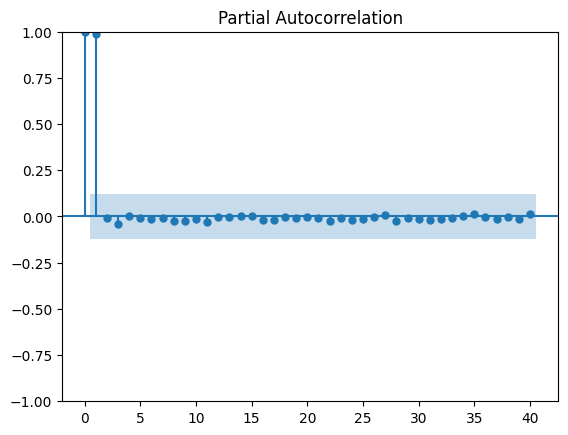

In [42]:
plot_pacf(df2['Inventories'], lags=40);

In [44]:
stepwise_fit = auto_arima(
    df2['Inventories'],
    start_p = 0,
    start_q = 0,
    max_p = 2,
    max_q = 2,
    seasonal=False,
    trace=True
).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.133 seconds


### 예측

(강의에는 (1,1,1)로 나와서 (0,1,0) 결과값 대체함)

In [45]:
train = df2.iloc[:252]
test = df2.iloc[252:]

In [63]:
model = ARIMA(train['Inventories'], order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2561.938
Date:                Sat, 10 Dec 2022   AIC                           5129.876
Time:                        21:16:16   BIC                           5140.453
Sample:                    01-01-1997   HQIC                          5134.132
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001    771.780      0.000       0.997       1.003
ma.L1         -1.0000      0.035    -28.802      0.000      -1.068      -0.932
sigma2      3.159e+07   3.63e-10   8.71e+16      0.000    3.16e+07    3.16e+07
===================================================================================
Ljung-Box (L1) (Q):                  87.23   Jarque-Bera (JB):               103.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -1.19
Prob(H) (two-sided):                  0.67   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.66e+31. Standard errors may be unstable.
"""

In [64]:
start = len(train)
end = len(train) + len(test) - 1

In [65]:
pred = results.predict(start=start, end=end, typ='levels').rename('ARIMA (1,1,1) pred')
pred

2018-01-01    2.105651e+06
2018-02-01    2.107552e+06
2018-03-01    2.109452e+06
2018-04-01    2.111353e+06
2018-05-01    2.113253e+06
2018-06-01    2.115154e+06
2018-07-01    2.117054e+06
2018-08-01    2.118954e+06
2018-09-01    2.120855e+06
2018-10-01    2.122755e+06
2018-11-01    2.124656e+06
2018-12-01    2.126556e+06
Freq: MS, Name: ARIMA (1,1,1) pred, dtype: float64

<AxesSubplot: xlabel='Date'>

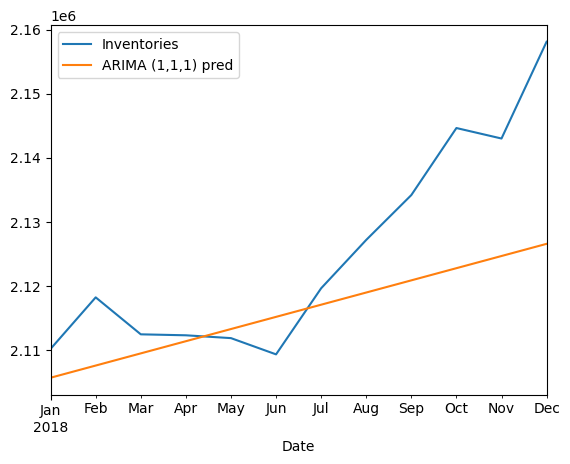

In [52]:
test['Inventories'].plot(legend=True)
pred.plot(legend=True)

### 평가

In [53]:
from statsmodels.tools.eval_measures import rmse

In [54]:
error = rmse(test['Inventories'], pred)
error

13670.290038639585

In [55]:
test['Inventories'].mean()

2125075.6666666665

In [56]:
pred.mean()

2116103.709359299

### 미래 예측

In [62]:
model = ARIMA(train['Inventories'], order=(1,1,1))
results = model.fit()
fcast = results.predict(start=len(df2), end=len(df2)+11, type='levels').rename('ARIMA(1,1,1) forcast')

<AxesSubplot: xlabel='Date'>

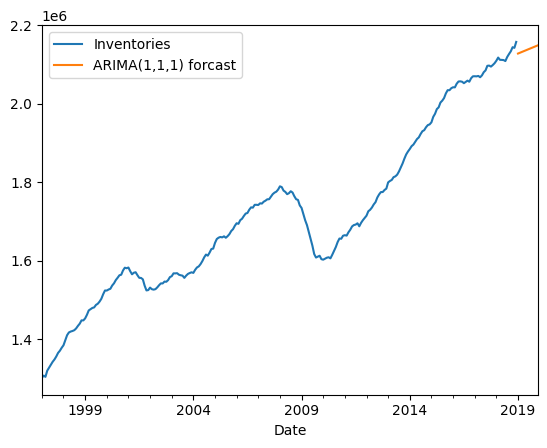

In [66]:
df2['Inventories'].plot(legend=True)
fcast.plot(legend=True)